A Quick Start to pyPetal
========================

pyPetal is a pipeline that contains 7 modules, each of which can be used optionally, and having its own parameters. A more in-depth description of the entire pipeline can be found in the API section.

The 7 modules available are:

* DRW (Damped Random Walk)-based outlier rejection
* Detrending
* pyCCF
* pyZDCF
* PyROA
* JAVELIN
* Weighting

Here, we'll describe the five main modules that can be used (DRW Rejection, pyCCF, pyZDCF, and JAVELIN). Detrending and weighting (as well as the other modules) are decsribed in detail in further tutorials and the API.

Main Arguments
--------------

pyPetal only takes a few required inputs to run, while all of the modules and their parameters are optional. The required inputs are:

* `output_dir`: The directory where the output files will be saved.
* `arg2`: Either a list of paths to the input light curves, or an array with the light curves themselves.

.. note:: The first light curve will be assumed to be the continuum light curve.

.. note:: All light curve files must be in the same directory and have the same format.

There are a few optional general arguments as well:

* `line_names` : A list of names corresponding to the light curves.
* `verbose` : If the progress (text only) should be printed.
* `plot` : If figures should be displayed throughout the run.
* `time_unit` : The unit of the time data for the input light curves.
* `lc_unit` : The units of the input light curves.
* `lag_bounds`: The bounds to search for the lag between two light curves.
* `threads`: The number of threads to use for multiprocessing.

DRW Rejection
-------------

The Damped Random Walk (DRW) is a popular model used to describe the variability of AGN data, with a power spectral density (PSD):

$P(f) = \frac{4 \sigma_{\rm DRW}^2 \tau_{\rm DRW} }{1 + (2\pi f \tau_{\rm DRW})^2}$

with two parameters: $\sigma_{\rm DRW}$, $\tau_{\rm DRW}$

 We can fit an arbitrary light curve (or a set of them) to a DRW model using the Gaussian process solver ``celerite`` with MCMC algorithm ``emcee``. In this example, we'll use PETL to fit each light curve to a DRW model and reject all points that are more than $3\sigma$ from the mean of the DRW fit.

In [1]:
import pypetal.pipeline as pl

main_dir = 'pypetal/examples/dat/javelin_'

filenames = [ main_dir + 'continuum.dat', main_dir + 'yelm.dat', main_dir + 'zing.dat' ]
output_dir = 'quickstart_ouput/'
line_names = ['Continuum', 'H-alpha', 'H-beta']


Performing DRW rejection
------------------------
jitter: True
nsig: 3
nwalker: 100
nburn: 300
nchain: 1000
clip: array
reject_data: [ True False False]
use_for_javelin: False
------------------------
        


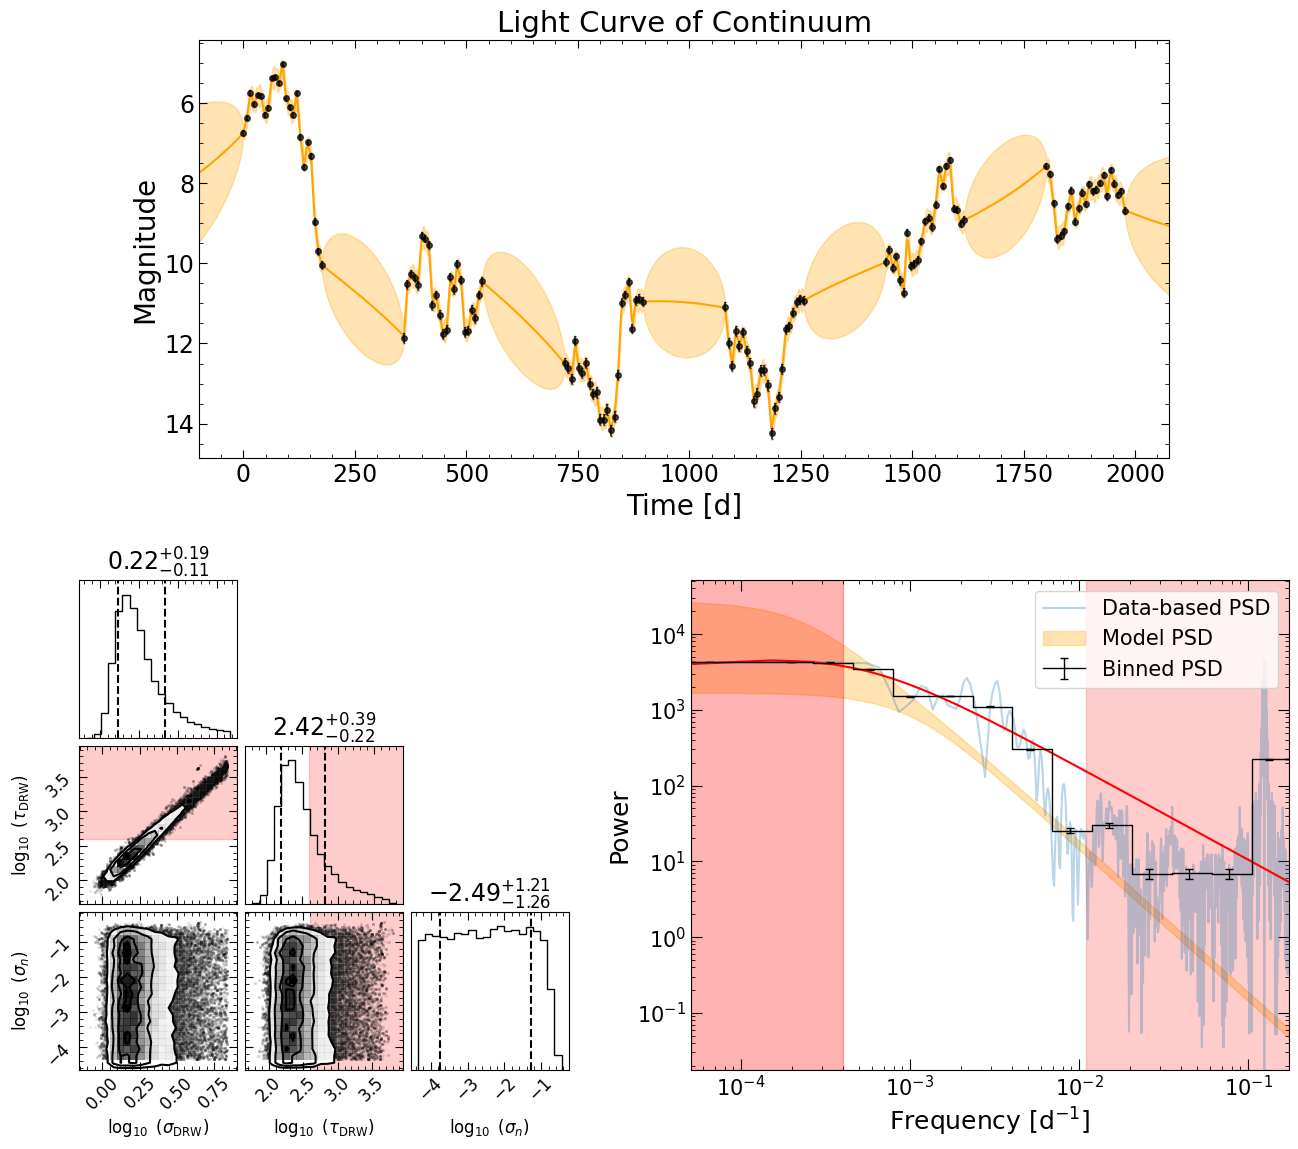

In [2]:
res = pl.run_pipeline( output_dir, filenames, line_names,
                       run_drw_rej=True, 
                       verbose=True,
                       plot=True,
                       file_fmt='ascii',
                       time_unit='d',
                       lc_unit='mag')

This will output a number of plots (like shown above) and diagnostic information in the specified ``output_dir``. In particular, the light curves will be saved in CSV format along with the DRW rejection masks in the ``light_curves`` subdirectory. The ``processed_lcs`` subdirectory will contain the light curves with the rejected points removed.

By default, only the first (i.e. continuum) will be fit to a DRW and have points rejected, though this can be specified in the ``reject_data`` argument.

pyCCF
-----

Now, we can utilize the ``pyCCF`` code to get the (interpolated) cross-correlation function between the continuum and the two light curves. To do this, we only need to specify ``run_pyccf=True`` in ``run_pipeline``.


Running pyCCF
-----------------
lag_bounds: [[-1976.98849, 1976.98849], [-1976.98849, 1976.98849]]
interp: 2.0000000001
nsim: 3000
mcmode: 0
sigmode: 0.2
thres: 0.8
nbin: 50
-----------------
        
Failed centroids:  0
Failed peaks:  0


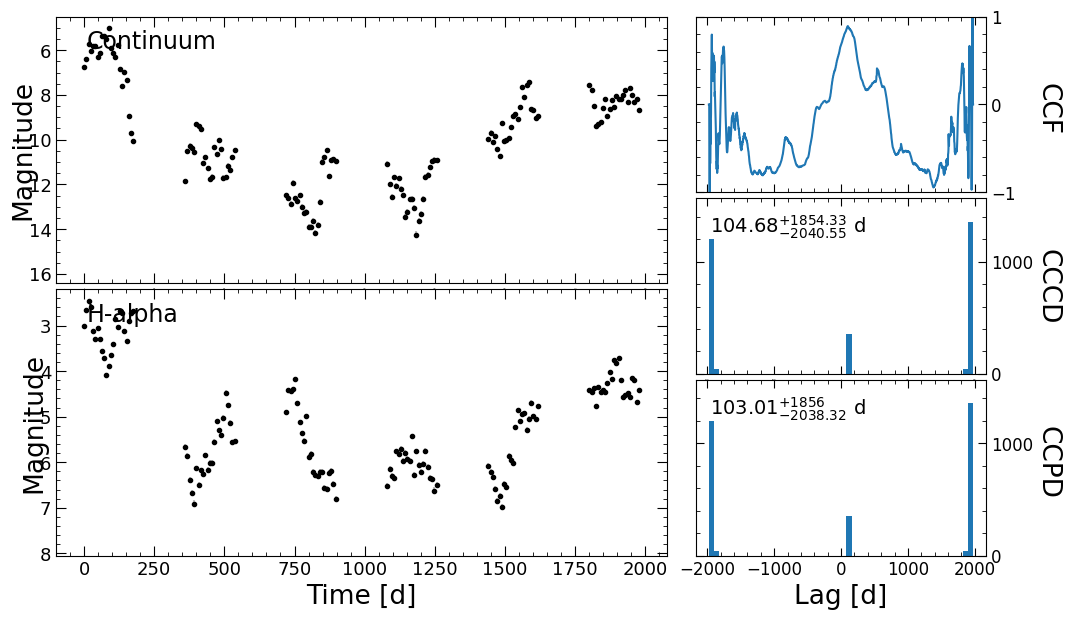

Failed centroids:  0
Failed peaks:  0


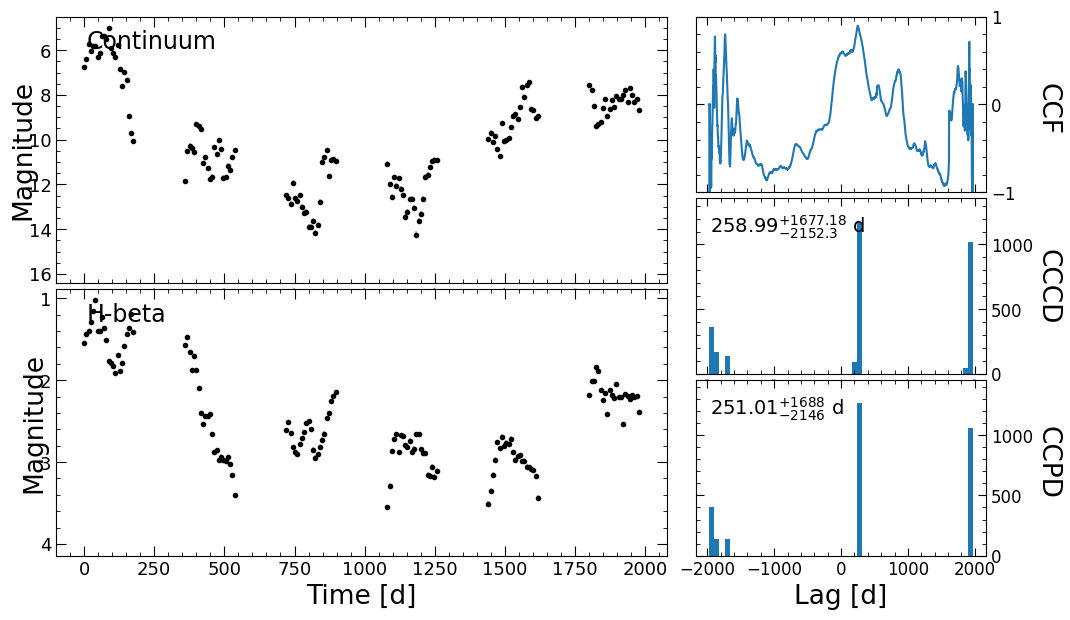

In [3]:
res = pl.run_pipeline( output_dir, filenames, line_names,
                       run_pyccf=True, 
                       verbose=True,
                       plot=True,
                       file_fmt='ascii',
                       time_unit='d',
                       lc_unit='mag',
                       threads=45)

This produced two plots showing the continuum of each of the lines, the cross-correlation function (CCF), the cross-correlation centroid distribution (CCCD), and the cross-correlation peak distribution (CCPD). 

pyZDCF
------

The next module in pyPetal is the ``pyZDCF`` module, which computes the Z-transformed Discrete Corrrelation Function between the continuum and each of the two lines. Similar to ``pyCCF``, we only need to specify ``run_pyzdcf=True`` in ``run_pipeline``.


Running pyZDCF
----------------------
nsim: 1000
minpts: 0
uniform_sampling: False
omit_zero_lags: True
sparse: auto
prefix: zdcf
run_plike: False
plike_dir: None
----------------------
        


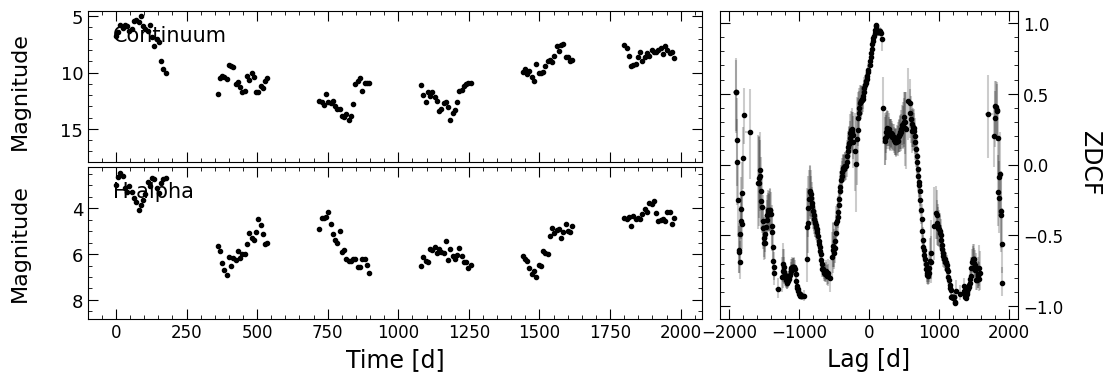

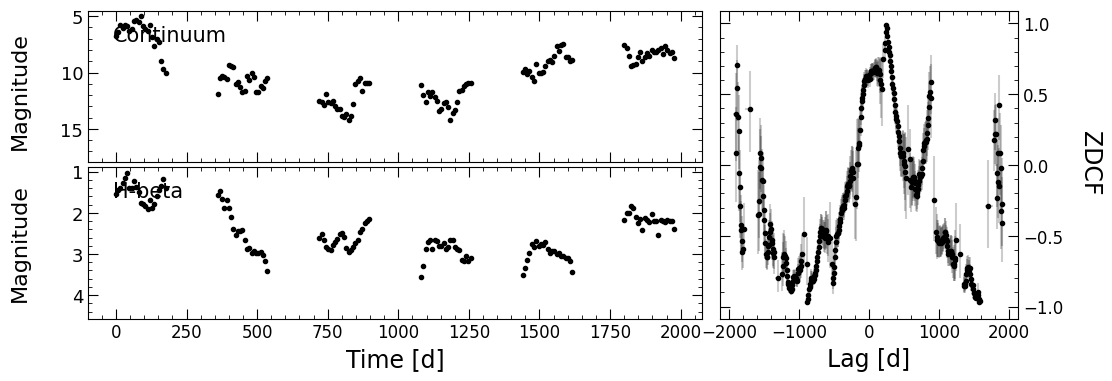

In [4]:
res = pl.run_pipeline( output_dir, filenames, line_names,
                       run_pyzdcf=True, 
                       verbose=True,
                       plot=True,
                       file_fmt='ascii',
                       time_unit='d',
                       lc_unit='mag')

PyROA
------

The next module in pyPetal uses the PyROA code, which finds and models the lag between two (or more) light curves using the running optimal average (ROA) technique. For more information, see the PyROA tutorial and the original PyROA code (and references therein).

To run this module, set ``run_pyroa=True`` in ``run_pipeline``.

By default, this will fit all lines to the continuum separately in one run. The light curves saved in PyROA's format will be stored in the ``pyroa_lcs`` subdorectory in the ``output_dir``. The diagnostic information and plots output from PyROA will be saved in the ``pyroa`` subdorectory in the ``output_dir``.


Running PyROA
----------------
nburn: 15000
nchain: 20000
init_tau: [10.0, 10.0]
subtract_mean: True
div_mean: False
add_var: True
delay_dist: True
psi_types: ['Gaussian', 'Gaussian']
together: True
objname: pyroa
----------------
        
Initial Parameter Values
     A0           B0    σ0       A1           B1    τ1    Δ1    σ1      A2          B2    τ2    Δ2    σ2    Δ
-------  -----------  ----  -------  -----------  ----  ----  ----  ------  ----------  ----  ----  ----  ---
2.30824  7.53021e-16  0.01  1.19302  4.11909e-16    10     1  0.01  0.5882  3.6042e-16    10     1  0.01   10
NWalkers=32


100%|██████████| 20000/20000 [43:15<00:00,  7.71it/s]


Filter: Continuum
Mean Delay, error: 0.00 (fixed)
Filter: H-alpha
Mean Delay, error:  100.23119  (+   1.04209 -   1.07512)
Filter: H-beta
Mean Delay, error:  250.36897  (+   0.88959 -   0.86571)


Best Fit Parameters
     A0           B0        σ0       A1          B1       τ1       Δ1        σ1        A2          B2       τ2       Δ2        σ2        Δ
-------  -----------  --------  -------  ----------  -------  -------  --------  --------  ----------  -------  -------  --------  -------
2.27618  0.000371373  0.341979  1.17664  -0.0226682  100.231  2.24521  0.189107  0.581586  0.00742638  250.369  1.65488  0.084886  11.9802


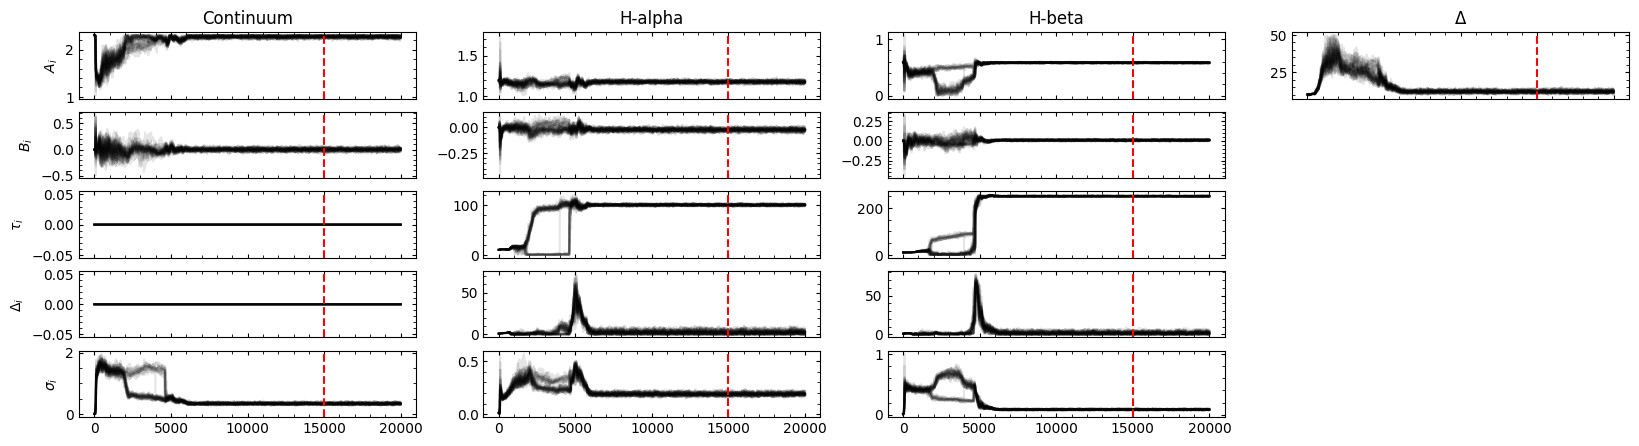

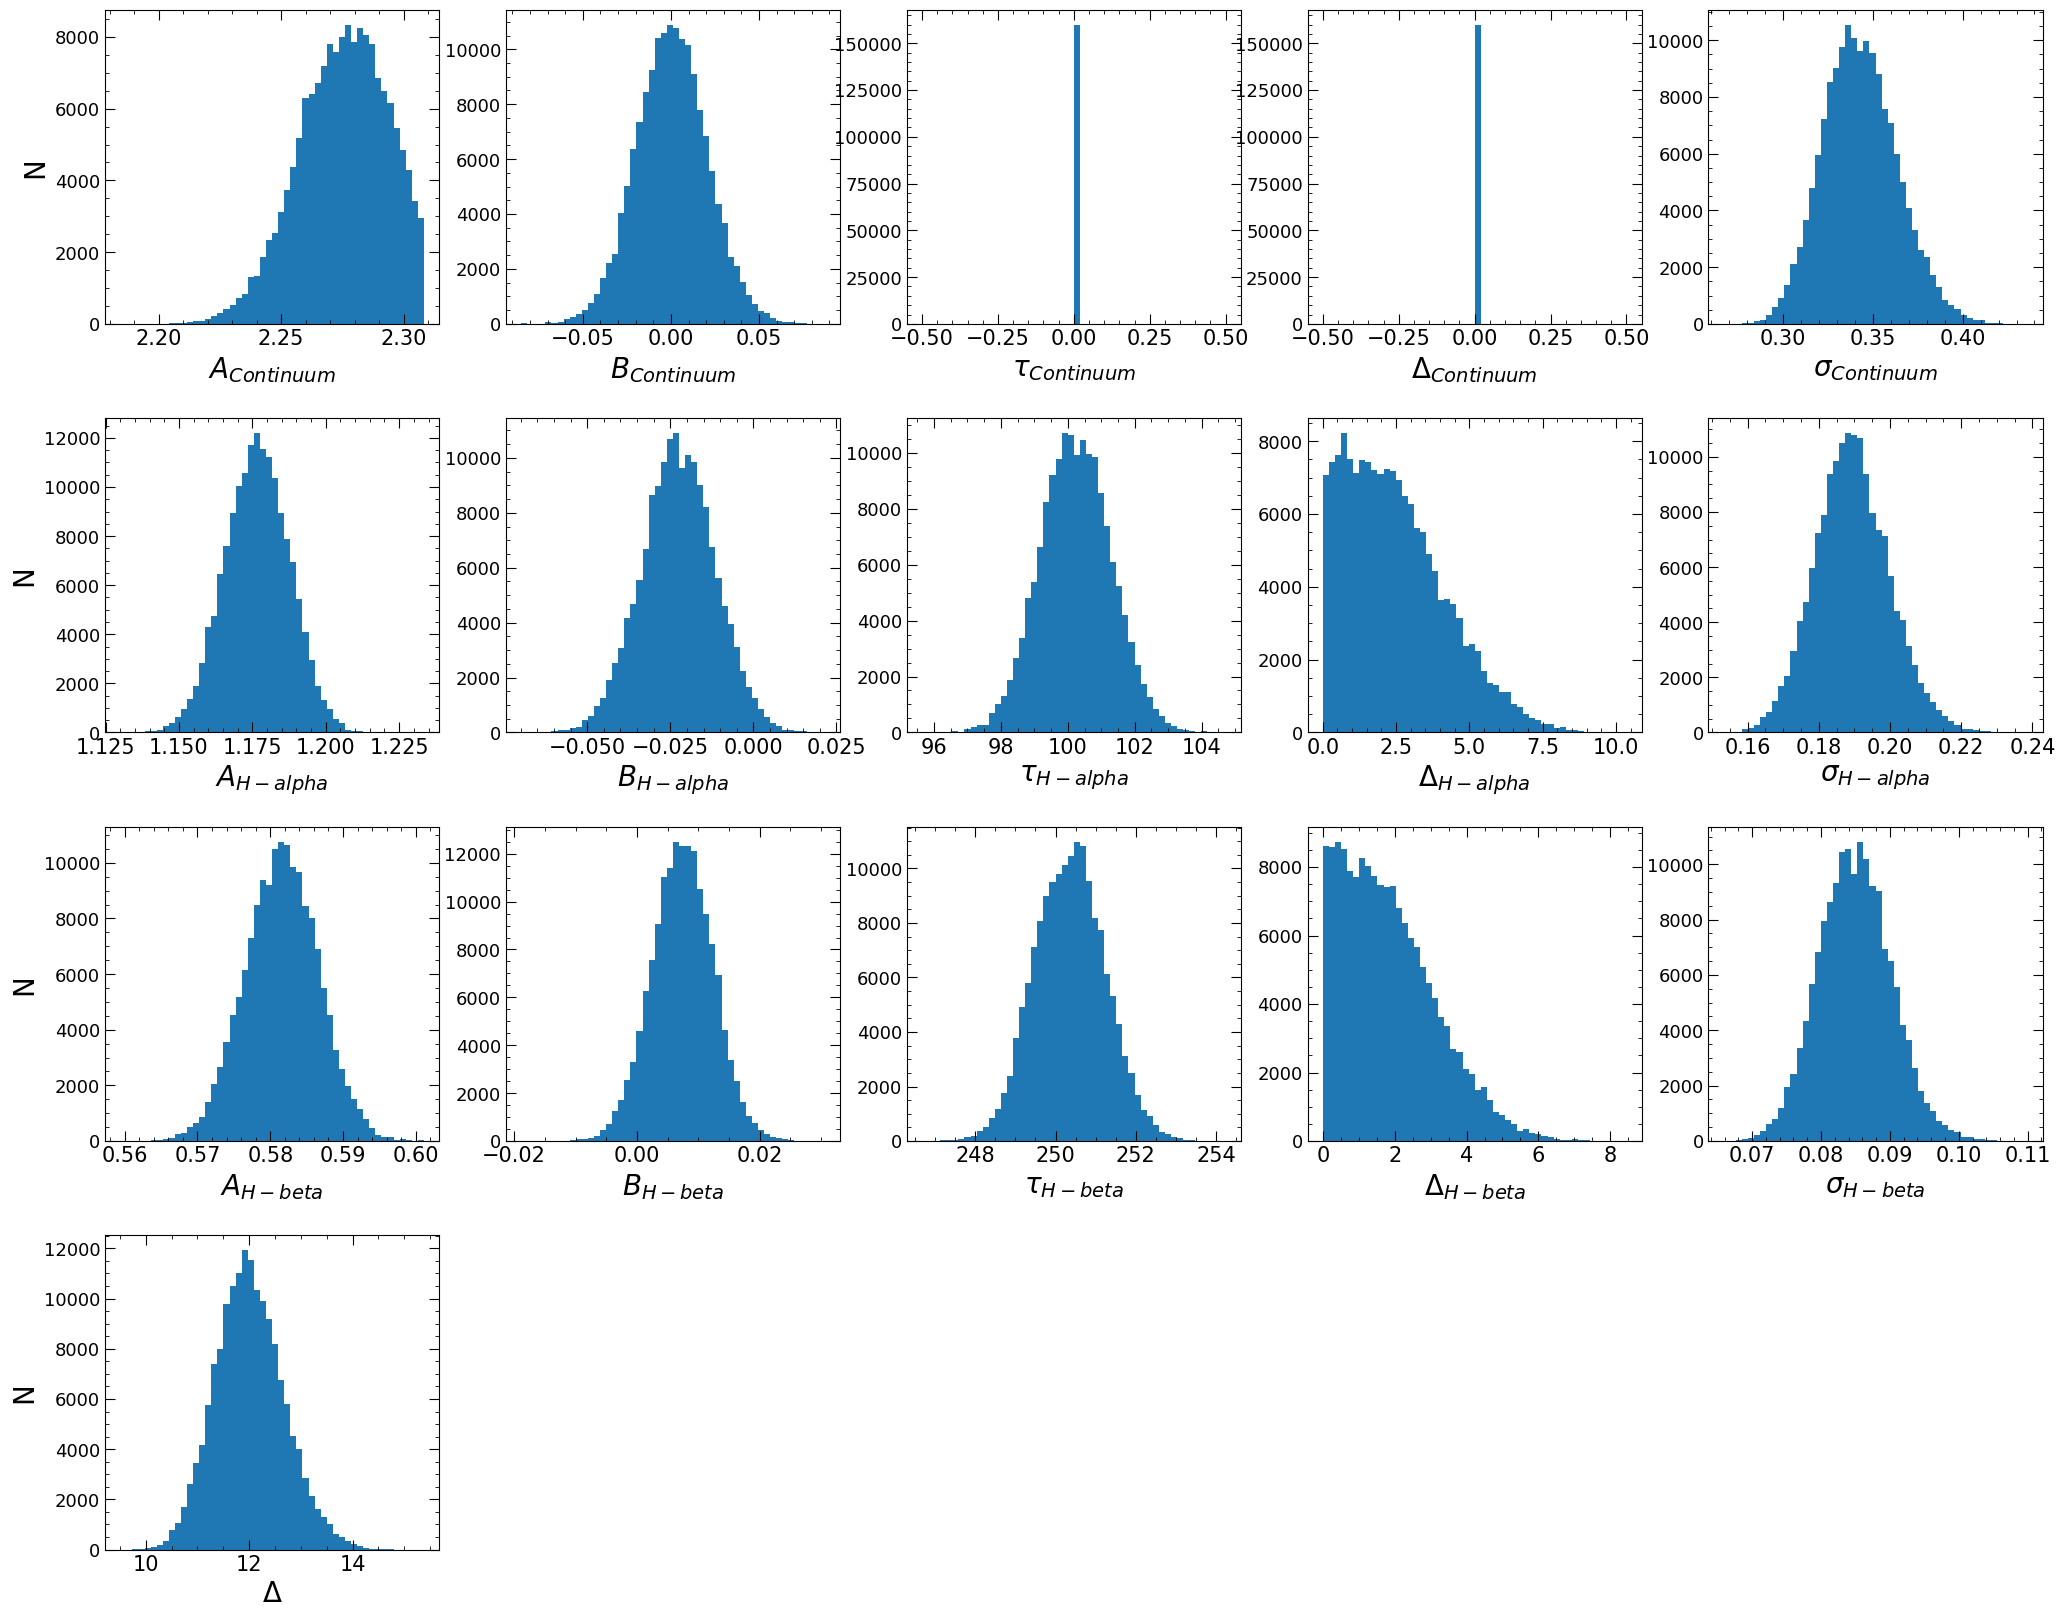

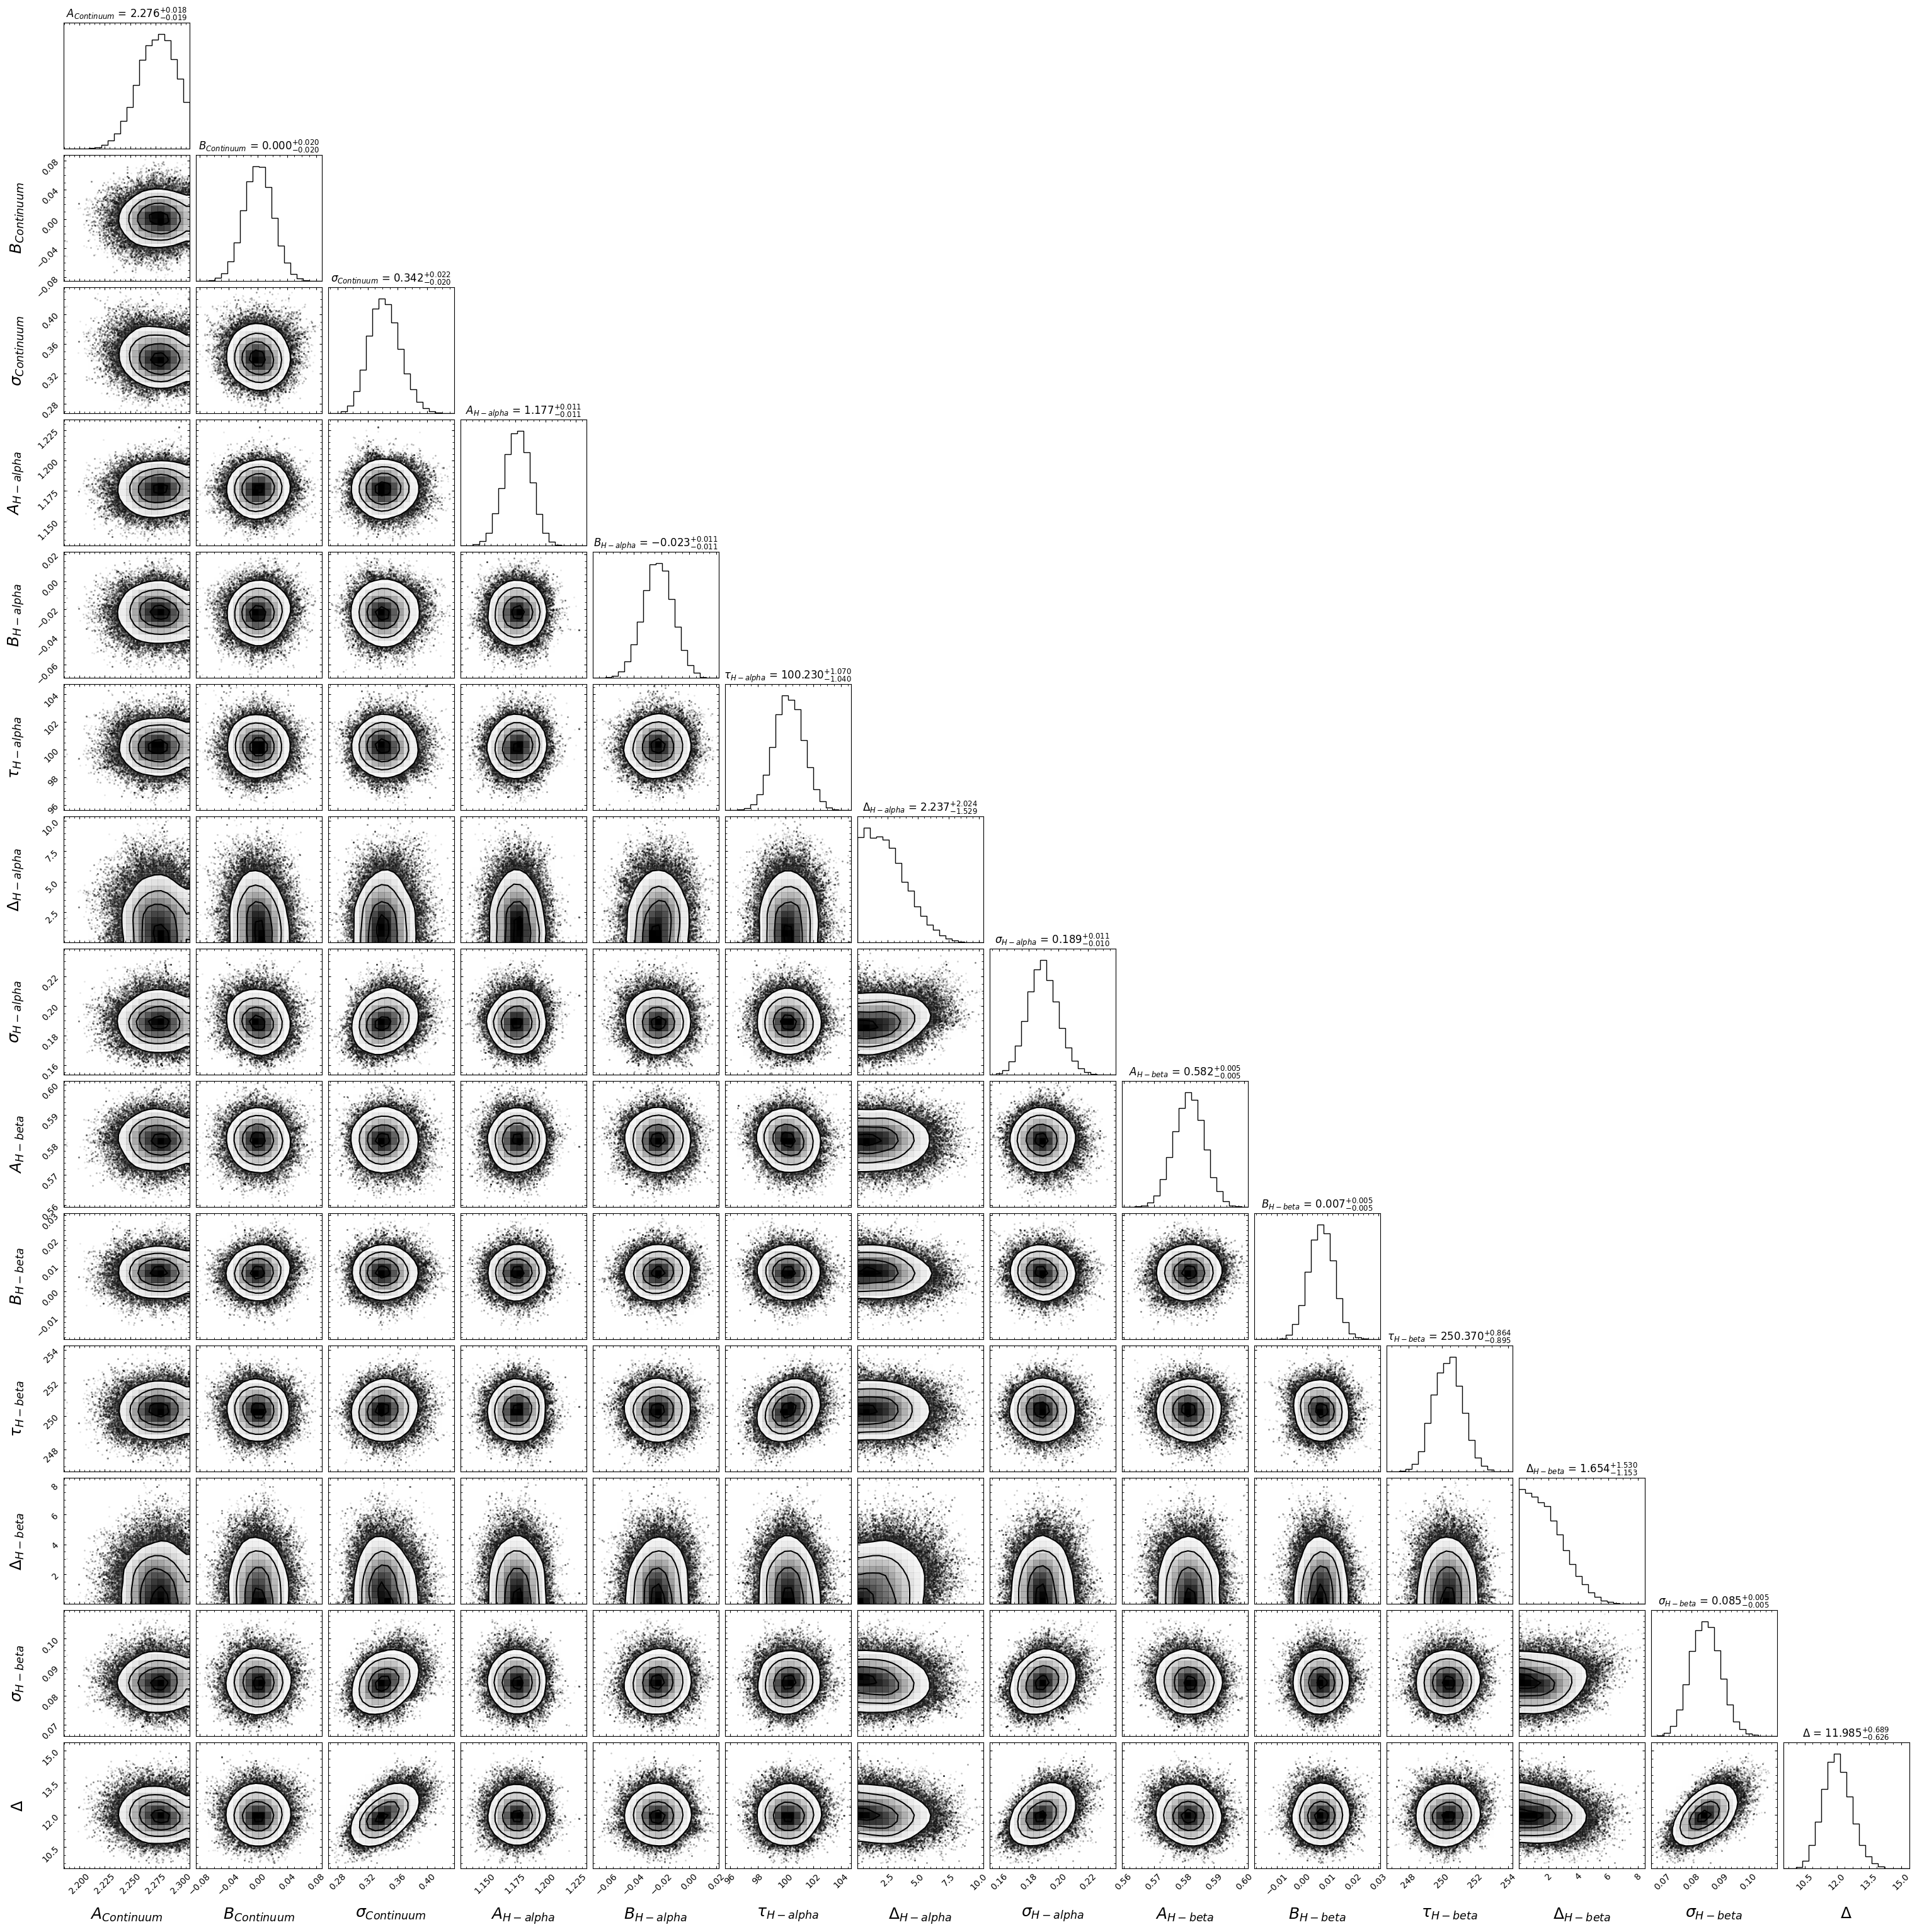

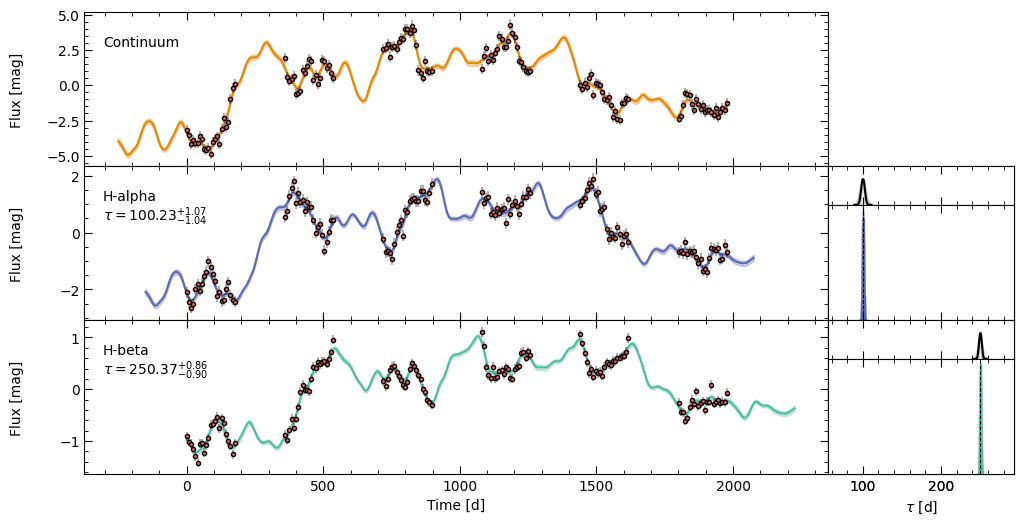

In [5]:
res = pl.run_pipeline( output_dir, filenames, line_names,
                       run_pyroa=True, 
                       verbose=True,
                       plot=True,
                       file_fmt='ascii',
                       time_unit='d',
                       lc_unit='mag')

JAVELIN
-------

The final module in pyPetal uses the JAVELIN code, which finds the lag between the continuum and multiple lines by interpolating with a fitted Damped Random Walk (DRW) model, convolved with a moving tophat function.

JAVELIN is unique in that it requires a separate version of Python (<3.0), and hence a separate package. This package, ``pypetal-jav``, can be installed through ``pip``, but must be used in a Python 2 environment.

To run this module, we can use the ``run_pipeline`` function in ``pypetal_jav.pipeline``. This requires the name of the ``output_dir`` from the original pyPetal run, and the line names.

This will fit each pair of continnum and line light curves to the DRW+tophat model, and output a number of plots and diagnostic information in each line's subdirectory in the ``output_dir``.  


Running JAVELIN
--------------------
rm_type: spec
lagtobaseline: 0.3
laglimit: [[-1976.98849, 1976.98849], [-1976.98849, 1976.98849]]
fixed: True
p_fix: True
subtract_mean: True
nwalker: 100
nburn: 100
nchain: 100
output_chains: True
output_burn: True
output_logp: True
nbin: 50
metric: med
together: False
--------------------
        
start burn-in
nburn: 100 nwalkers: 100 --> number of burn-in iterations: 10000
burn-in finished
save burn-in chains to /home/stone28/pypetal/quickstart_ouput/H-alpha/javelin/burn_cont.txt
start sampling
sampling finished
acceptance fractions for all walkers are
0.69 0.68 0.67 0.70 0.67 0.72 0.65 0.73 0.66 0.74 0.77 0.70 0.67 0.71 0.73 0.71 0.67 0.73 0.79 0.65 0.73 0.65 0.72 0.69 0.62 0.68 0.63 0.67 0.66 0.72 0.62 0.73 0.70 0.75 0.64 0.68 0.66 0.74 0.64 0.63 0.79 0.68 0.73 0.70 0.69 0.72 0.70 0.68 0.71 0.65 0.75 0.75 0.59 0.71 0.75 0.69 0.69 0.74 0.77 0.70 0.73 0.63 0.77 0.68 0.74 0.77 0.73 0.69 0.79 0.74 0.66 0.74 0.65 0.72 0.69 0.75 0.71 0.65 0.66 0.74

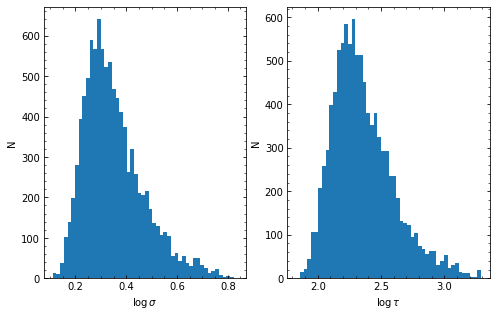

run parallel chains of number 45 
start burn-in
using priors on sigma and tau from continuum fitting
[[  1.742 135.553]
 [  2.131 207.09 ]
 [  2.931 387.869]]
penalize lags longer than 0.30 of the baseline
nburn: 100 nwalkers: 100 --> number of burn-in iterations: 10000
burn-in finished
save burn-in chains to /home/stone28/pypetal/quickstart_ouput/H-alpha/javelin/burn_rmap.txt
start sampling
sampling finished
acceptance fractions are
0.08 0.02 0.00 0.09 0.06 0.04 0.09 0.09 0.03 0.02 0.12 0.02 0.15 0.07 0.06 0.03 0.06 0.07 0.03 0.10 0.02 0.08 0.06 0.12 0.19 0.11 0.10 0.01 0.10 0.07 0.08 0.06 0.09 0.09 0.00 0.13 0.12 0.03 0.10 0.07 0.09 0.02 0.10 0.13 0.12 0.00 0.05 0.09 0.08 0.03 0.03 0.06 0.04 0.07 0.11 0.04 0.05 0.16 0.06 0.09 0.06 0.15 0.06 0.14 0.06 0.03 0.10 0.06 0.05 0.09 0.14 0.04 0.00 0.06 0.10 0.04 0.14 0.02 0.00 0.14 0.09 0.08 0.10 0.00 0.12 0.07 0.04 0.07 0.08 0.09 0.04 0.06 0.14 0.16 0.05 0.09 0.03 0.19 0.06 0.03
save MCMC chains to /home/stone28/pypetal/quickstart_ouput/H-a

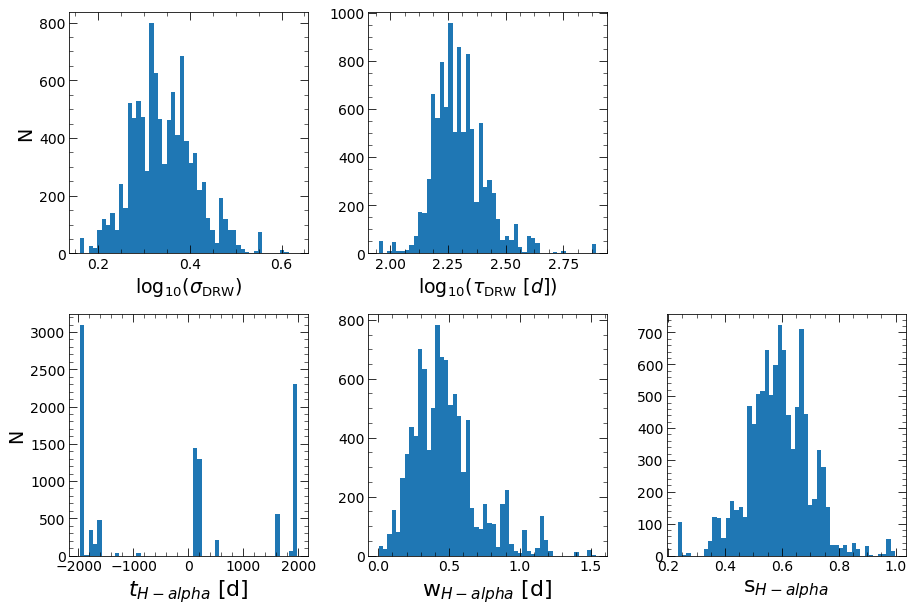

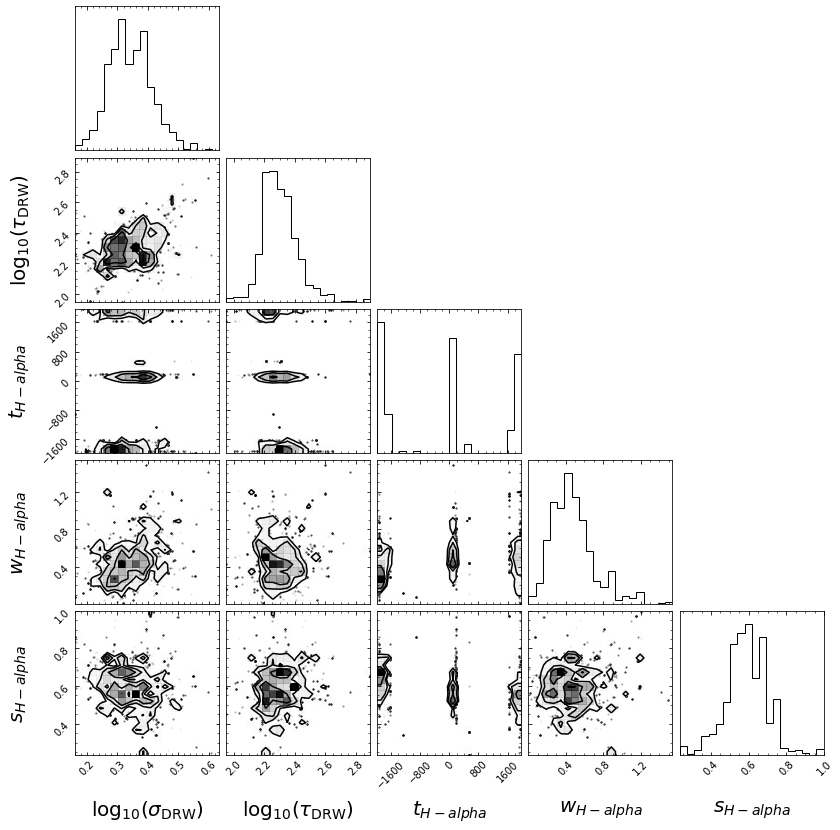

covariance matrix calculated
covariance matrix decomposed and updated by U


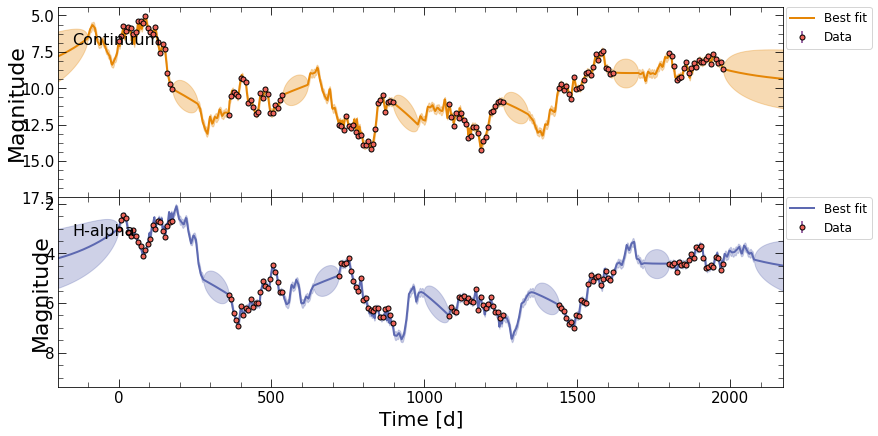

start burn-in
nburn: 100 nwalkers: 100 --> number of burn-in iterations: 10000
burn-in finished
save burn-in chains to /home/stone28/pypetal/quickstart_ouput/H-beta/javelin/burn_cont.txt
start sampling
sampling finished
acceptance fractions for all walkers are
0.72 0.78 0.70 0.75 0.64 0.74 0.69 0.70 0.65 0.71 0.73 0.69 0.65 0.64 0.66 0.84 0.68 0.77 0.81 0.73 0.71 0.68 0.73 0.69 0.70 0.75 0.78 0.73 0.77 0.71 0.73 0.57 0.70 0.65 0.75 0.72 0.60 0.65 0.65 0.76 0.71 0.79 0.73 0.69 0.69 0.73 0.68 0.77 0.75 0.66 0.75 0.69 0.63 0.69 0.71 0.67 0.77 0.69 0.77 0.70 0.70 0.73 0.72 0.80 0.72 0.76 0.72 0.73 0.60 0.68 0.68 0.66 0.73 0.80 0.77 0.70 0.65 0.69 0.57 0.75 0.76 0.67 0.75 0.70 0.79 0.73 0.68 0.74 0.67 0.76 0.68 0.60 0.65 0.71 0.71 0.70 0.69 0.74 0.68 0.75
save MCMC chains to /home/stone28/pypetal/quickstart_ouput/H-beta/javelin/chain_cont.txt
save logp of MCMC chains to /home/stone28/pypetal/quickstart_ouput/H-beta/javelin/logp_cont.txt
HPD of sigma
low:    1.768 med    2.205 hig    3.015
H

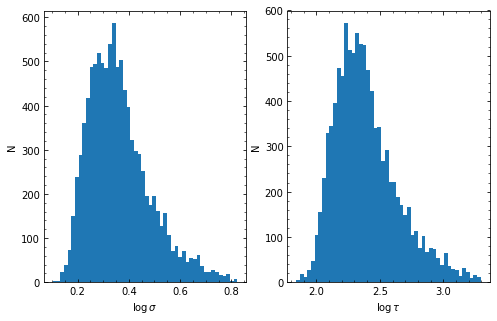

run parallel chains of number 45 
start burn-in
using priors on sigma and tau from continuum fitting
[[  1.768 143.548]
 [  2.205 224.383]
 [  3.015 428.443]]
penalize lags longer than 0.30 of the baseline
nburn: 100 nwalkers: 100 --> number of burn-in iterations: 10000
burn-in finished
save burn-in chains to /home/stone28/pypetal/quickstart_ouput/H-beta/javelin/burn_rmap.txt
start sampling
sampling finished
acceptance fractions are
0.04 0.02 0.13 0.08 0.00 0.03 0.06 0.01 0.03 0.06 0.08 0.17 0.08 0.14 0.10 0.19 0.12 0.10 0.06 0.02 0.16 0.02 0.14 0.17 0.02 0.10 0.14 0.15 0.08 0.21 0.09 0.02 0.12 0.02 0.08 0.05 0.02 0.18 0.02 0.09 0.01 0.05 0.17 0.10 0.04 0.06 0.02 0.14 0.04 0.04 0.13 0.13 0.13 0.11 0.09 0.04 0.08 0.13 0.00 0.12 0.03 0.09 0.06 0.07 0.09 0.07 0.09 0.11 0.07 0.15 0.01 0.09 0.09 0.07 0.03 0.06 0.04 0.10 0.09 0.17 0.07 0.12 0.09 0.11 0.02 0.15 0.11 0.11 0.17 0.04 0.06 0.11 0.13 0.03 0.10 0.06 0.13 0.11 0.00 0.11
save MCMC chains to /home/stone28/pypetal/quickstart_ouput/H-be

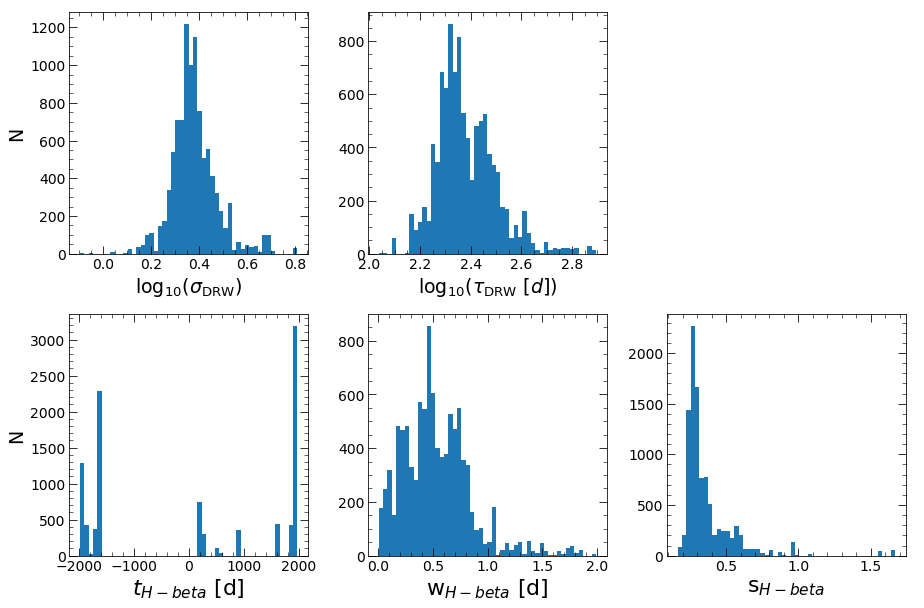

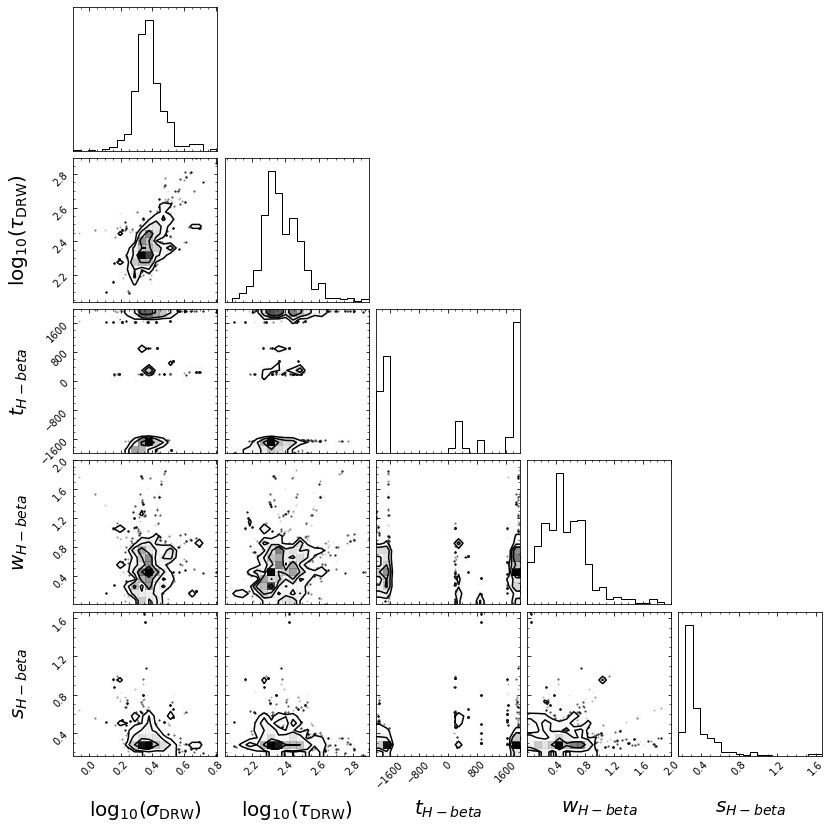

covariance matrix calculated
covariance matrix decomposed and updated by U


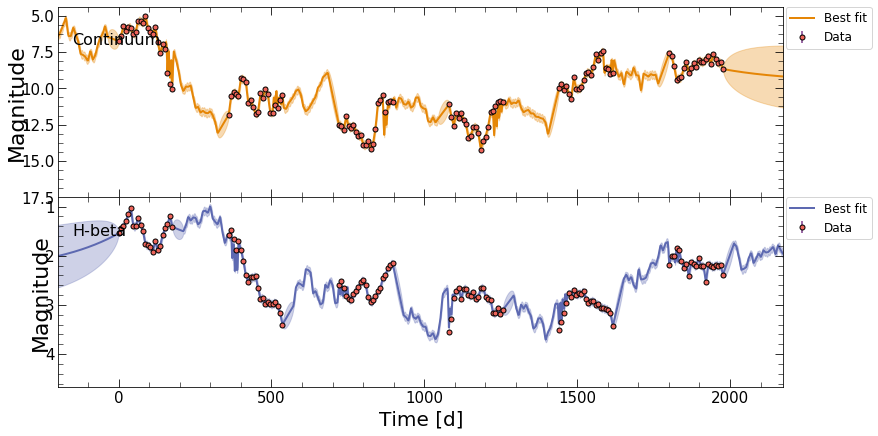

In [2]:
#Assuming we are now in the Python 2 environment with pypetal-jav installed
import pypetal_jav.pipeline as plj

main_dir = 'pypetal/examples/dat/javelin_'

filenames = [ main_dir + 'continuum.dat', main_dir + 'yelm.dat', main_dir + 'zing.dat' ]
output_dir = 'quickstart_ouput/'
line_names = ['Continuum', 'H-alpha', 'H-beta']

res = plj.run_pipeline( output_dir, line_names,
                       verbose=True,
                       plot=True,
                       file_fmt='ascii',
                       time_unit='d',
                       lc_unit='mag',
                       threads=45)

Those are the basics of pyPetal! There will be an output directory structured in the following way:

```
    quickstart_output/
    ├── Continuum/
    │   └── drw_rej/
    ├── H-alpha/
    │   ├── drw_rej/
    │   ├── pyccf/
    │   ├── pyzdcf/
    │   └── javelin/
    ├── H-beta/
    │   ├── drw_rej/
    │   ├── pyccf/
    │   ├── pyzdcf/
    │   └──javelin/
    ├── processed_lcs/
    ├── pyroa/
    ├── pyroa_lcs/
    └── light_curves/
```

For a more in-depth look at the input options for each module and the output files and figures, see the other tutorials and API documentation.